<a href="https://colab.research.google.com/github/plaban1981/Generative_AI/blob/main/Auto_Stable_Diifusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

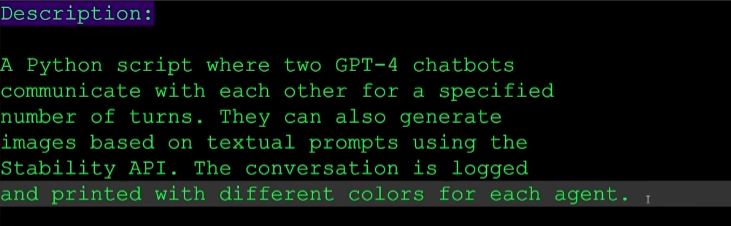

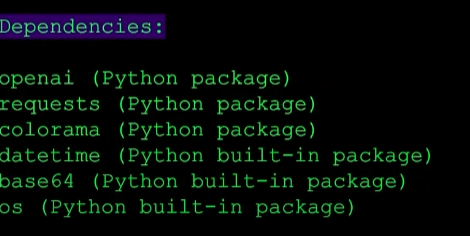

## Install Dependencies

In [1]:
!pip install -qU openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 7.8 MB/s eta 0:00:00


In [3]:
!pip install -qU colorama

## Import Dependencies

In [4]:
import openai
import os
import requests
import re
from colorama import Fore, Style, init
import datetime
import base64

## Workflow

1. open_file(file_path) : Open Files and read the content
2. save_file(file_path,content) : save the contents to a file.
3. chatgptapi
4. generate image
5. print colored image

In [5]:
# Initialize colorama
init()

# Define a function to open a file and return its contents as a string
def open_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as infile:
        return infile.read()

# Define a function to save content to a file
def save_file(filepath, content):
    with open(filepath, 'a', encoding='utf-8') as outfile:
        outfile.write(content)

In [16]:
from getpass import getpass
# Set the OpenAI API keys by reading them from files
api_key = getpass()

#sd api key : https://beta.dreamstudio.ai/account
sd_api_key = getpass()

··········
··········


In [41]:
# Initialize two empty lists to store the conversations for each chatbot
conversation1 = []
conversation2 = []

In [33]:
%%writefile chatbot3.txt
Your name is AgentX. Your friend AgentY can create images when you tell him to. Your task is tell AgentY to create the images you describe to him. You must describe the image is a very detailed way. Artstyle, artist, lenses, colors, etc.

The Images you want: The image is a hyperrealistic photo of a fashion model wearing a futuristic suit with silver and metalic linings on the dress walking on the runway with bright studio lights and audience watching the model walk.

You will ALWAYS converse in this structure:

Response: Here is where you respond to AgentY.

Overwriting chatbot3.txt


In [25]:
%%writefile chatbot4.txt
Your name is AgentY. Your friend AgentX will tell you describtions of images she wants to see. Your task is to create 10 images she describes to you by running the special command generate_image: + the text prompt as the input after the command.

You will ALWAYS converse in this structure:

Response: Here is where you respond to AgentX
Image: Here is where you run the special command "generate_image:the text prompt" when AgentX tells you an image describtion.

Overwriting chatbot4.txt


In [42]:
# Read the content of the files containing the chatbots' prompts
chatbot1 = open_file('chatbot4.txt')
chatbot2 = open_file('chatbot3.txt')

## Define a function to make an API call to the OpenAI ChatCompletion endpoint

In [37]:
def chatgpt(api_key, conversation, chatbot, user_input, temperature=0.75, frequency_penalty=0.2, presence_penalty=0):

    # Set the API key
    openai.api_key = api_key

    # Update conversation by appending the user's input
    conversation.append({"role": "user","content": user_input})

    # Insert prompt into message history
    messages_input = conversation.copy()
    prompt = [{"role": "system", "content": chatbot}]
    messages_input.insert(0, prompt[0])

    # Make an API call to the ChatCompletion endpoint with the updated messages
    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        temperature=temperature,
        frequency_penalty=frequency_penalty,
        presence_penalty=presence_penalty,
        messages=messages_input)

    # Extract the chatbot's response from the API response
    chat_response = completion['choices'][0]['message']['content']

    # Update conversation by appending the chatbot's response
    conversation.append({"role": "assistant", "content": chat_response})

    # Return the chatbot's response
    return chat_response

## Define a function to generate images using the Stability API 

In [18]:
import os
os.mkdir("SDimages")

In [19]:
def generate_image(api_key, text_prompt, height=512, width=512, cfg_scale=7, clip_guidance_preset="FAST_BLUE", steps=50, samples=1):
    api_host = 'https://api.stability.ai'
    engine_id = "stable-diffusion-xl-beta-v2-2-2"

    response = requests.post(
        f"{api_host}/v1/generation/{engine_id}/text-to-image",
        headers={
            "Content-Type": "application/json",
            "Accept": "application/json",
            "Authorization": f"Bearer {api_key}"
        },
        json={
            "text_prompts": [
                {
                    "text": text_prompt
                }
            ],
            "cfg_scale": cfg_scale,
            "clip_guidance_preset": clip_guidance_preset,
            "height": height,
            "width": width,
            "samples": samples,
            "steps": steps,
        },
    )

    if response.status_code != 200:
        raise Exception("Non-200 response: " + str(response.text))

    data = response.json()
    image_data = data["artifacts"][0]["base64"]

    # Save the generated image to a file with a unique name in the "SDimages" folder
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    image_filename = os.path.join("/content/SDimages", f"generated_image_{timestamp}.png")

    with open(image_filename, "wb") as f:
        f.write(base64.b64decode(image_data))

    return image_filename

In [14]:
# Add a function to print text in green if it contains certain keywords
def print_colored(agent, text):
    agent_colors = {
        "Agent69:": Fore.YELLOW,
        "Agent007:": Fore.CYAN,
    }

    color = agent_colors.get(agent, "")

    print(color + f"{agent}: {text}" + Style.RESET_ALL, end="")  


In [43]:
num_turns = 2  # Number of turns for each chatbot (you can adjust this value)

# Start the conversation with ChatBot1's first message
user_message = "Hello AgentY, I am AgentX. How can i help you?"

# Update the loop where chatbots talk to each other
for i in range(num_turns):
    print_colored("AgentX:", f"{user_message}\n\n")
    save_file("ChatLog.txt", "AgentX: " + user_message + "\n\n")
    response = chatgpt(api_key, conversation1, chatbot1, user_message)
    user_message = response
    
    if "generate_image:" in user_message:
        image_prompt = user_message.split("generate_image:")[1].strip()
        image_path = generate_image(sd_api_key, image_prompt)
        print(f"Generated image: {image_path}")    

    print_colored("AgentY:", f"{user_message}\n\n")
    save_file("ChatLog.txt", "AgentY: " + user_message + "\n\n")
    response = chatgpt(api_key, conversation2, chatbot2, user_message)
    user_message = response
    
    if "generate_image:" in user_message:
        image_prompt = user_message.split("generate_image:")[1].strip()
        image_path = generate_image(sd_api_key, image_prompt)
        print(f"Generated image: {image_path}")    
    

AgentX:: Hello AgentY, I am AgentX. How can i help you?

AgentY:: Hello AgentX, I'm ready to create the images you request. What would you like me to create first?

AgentX:: Great, AgentY! I would like you to create a hyperrealistic photo of a fashion model walking on the runway. The model should be wearing a futuristic suit with silver and metallic linings on the dress. The art style should be realistic and highly detailed, with the model appearing as if she is actually walking down a runway. The colors of the suit should be bright and eye-catching, with the metallic linings reflecting the bright studio lights around. The audience watching the show should be visible in the background, but not too prominent as to take away from the model's presence. Can you create this image for me?

Generated image: /content/SDimages/generated_image_20230423-153700.png
AgentY:: Certainly, AgentX! I will generate the image you described using advanced AI technology. Here is your hyperrealistic photo of

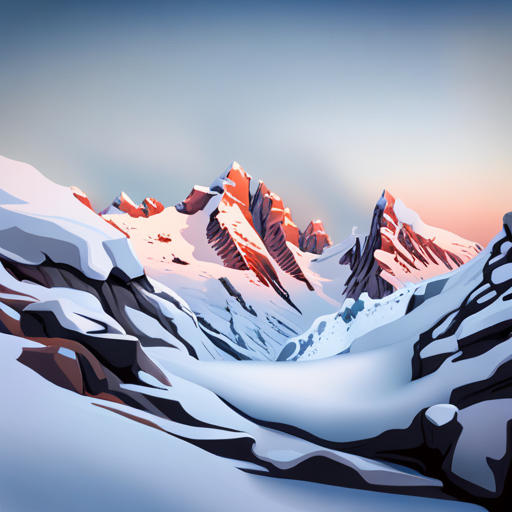

In [22]:
from IPython.display import display
from PIL import Image
display(Image.open("/content/SDimages/generated_image_20230423-151253.png"))

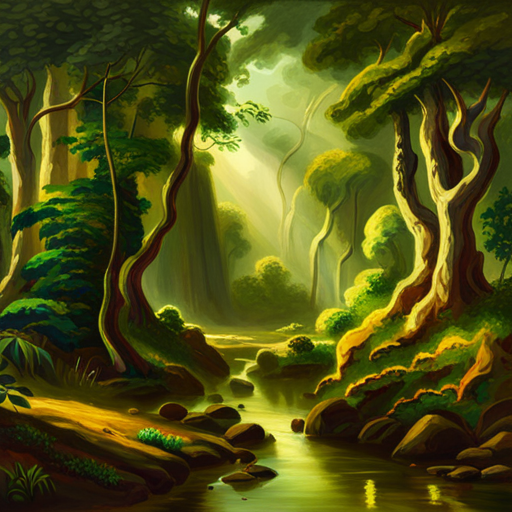

In [30]:
display(Image.open("/content/SDimages/generated_image_20230423-152152.png"))

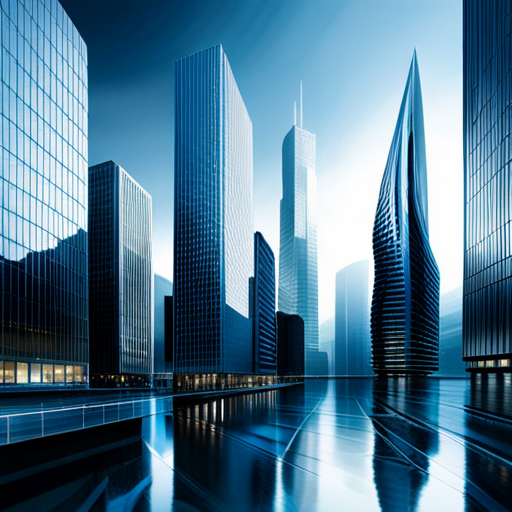

In [32]:
display(Image.open("/content/SDimages/generated_image_20230423-152459.png"))

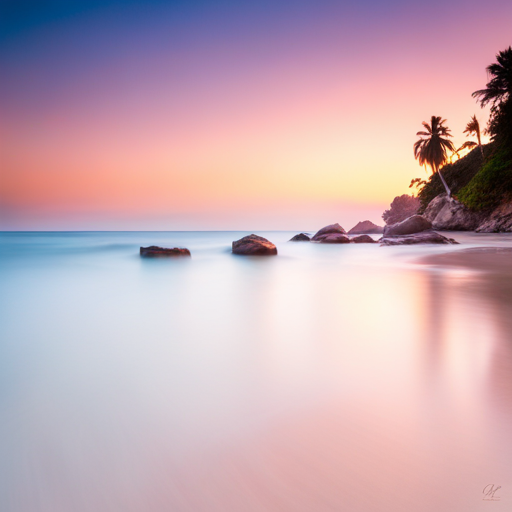

In [38]:
display(Image.open("/content/SDimages/generated_image_20230423-153113.png"))

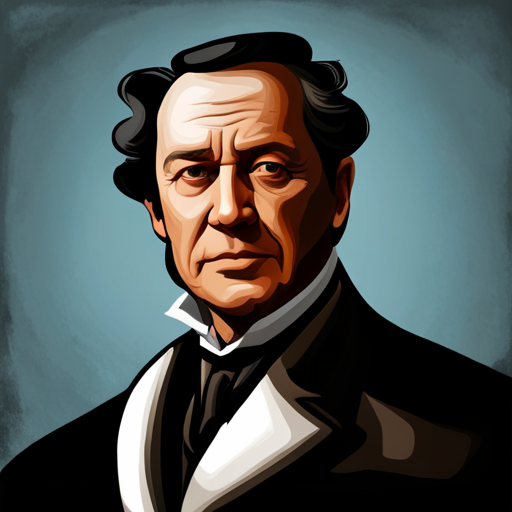

In [40]:
display(Image.open("/content/SDimages/generated_image_20230423-153339.png"))

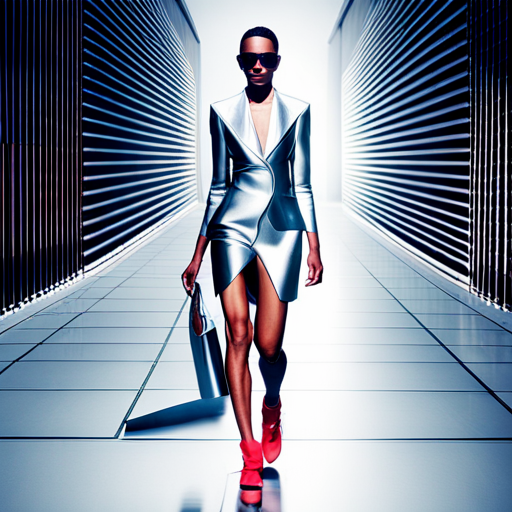

In [44]:
display(Image.open("/content/SDimages/generated_image_20230423-153700.png"))

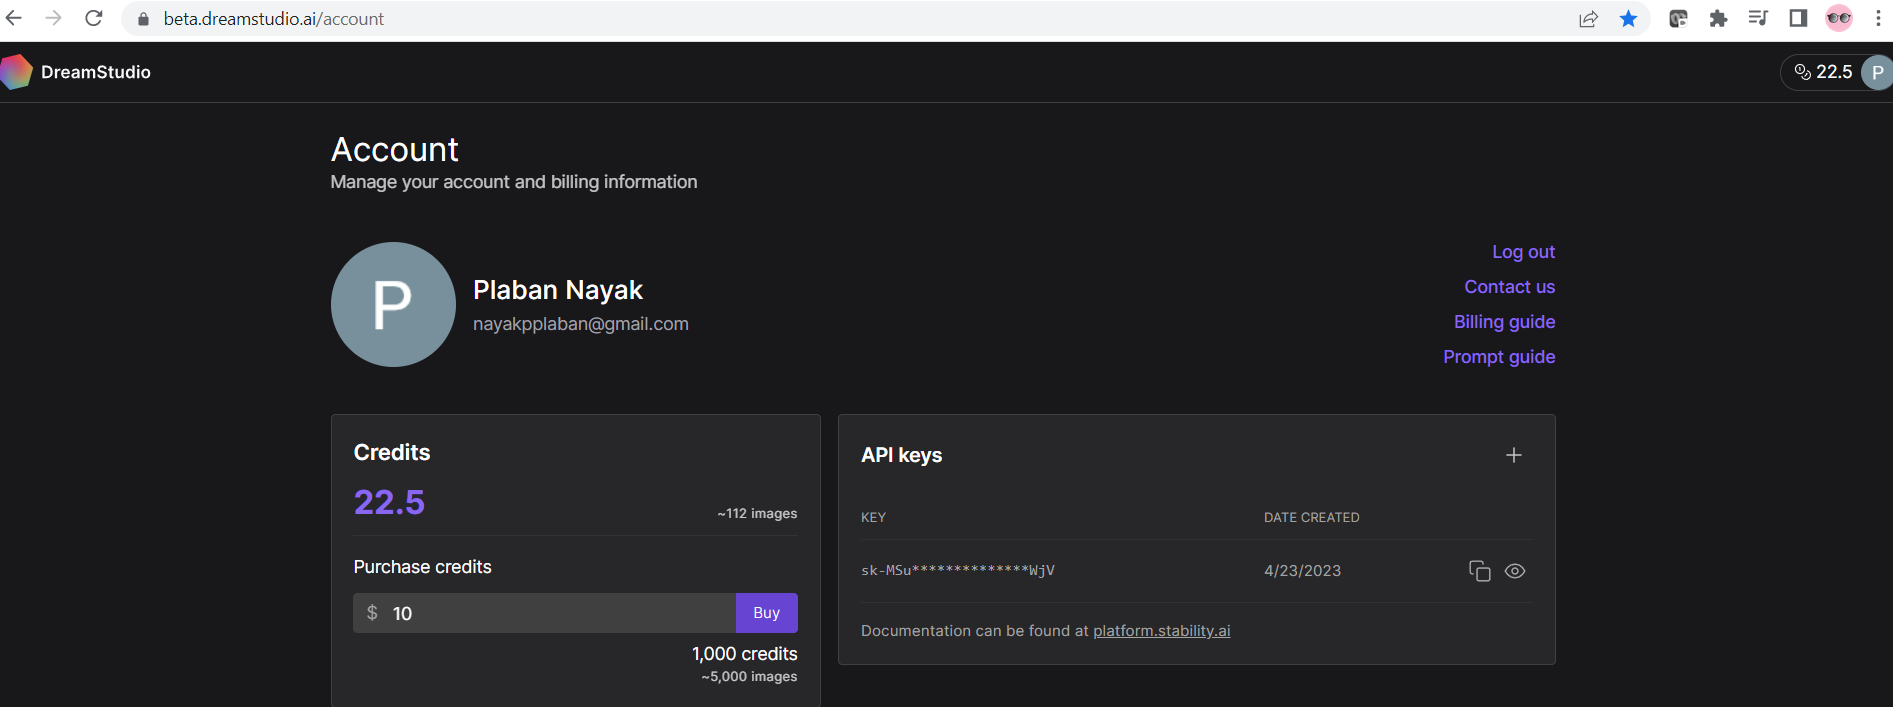

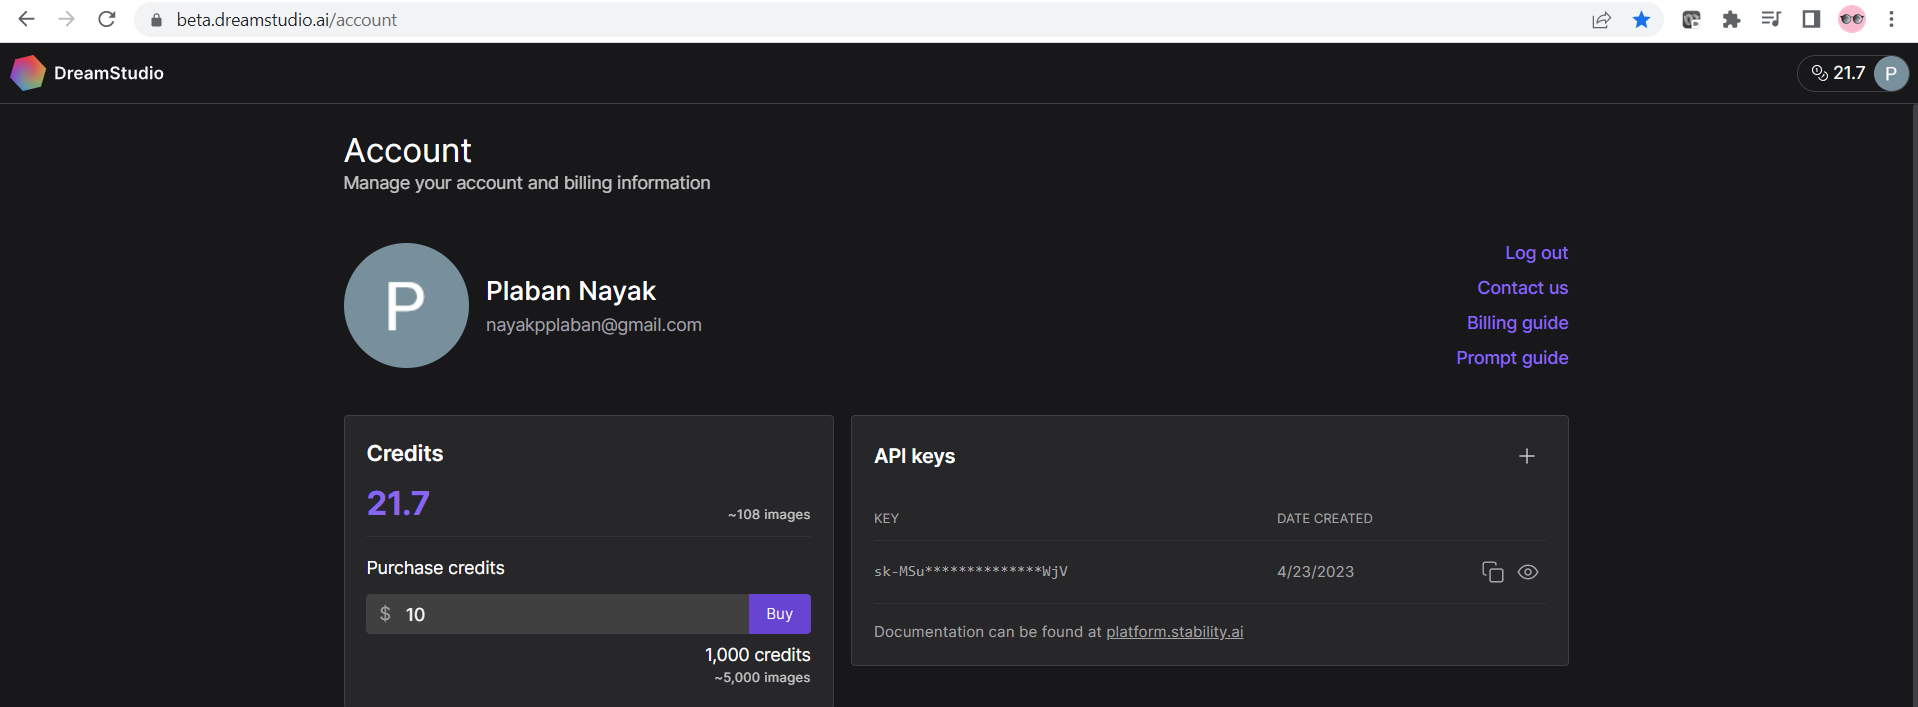